<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Modelling Ames Housing Data and Kaggle Challenge  
## PART 2/2: Linear Regression Modeling and Conclusion

----

### Re-importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
train = pd.read_csv('../dataset/train_clean.csv')
test = pd.read_csv('../dataset/test_clean.csv')

In [3]:
for name,df in zip(['train','test'],[train,test]):
    print(name)
    print(f"nullvalues = {df.isnull().sum().sum()}")
    print(df.columns)
    print('-------')

train
nullvalues = 0
Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond',
       'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2',
       'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF',
       'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr',
       'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces',
       'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'G

### 3. Hypothesis Testing

Do Above Ground Living Area, Age of Property at Sale and Neighborhood have any impact on Property Sale Price?

**Null hypothesis**: Gr Liv Area, Age of Property at Sale, External Quality and Neighborhood DO NOT have any impact on Property Sale Price. The coefficients of these features are equal to zero. 

**Alternative hypothesis**: Gr Liv Area, Age of Property at Sale, External Quality and Neighborhood are significant predictors of Property Sale Price. The coefficients of these features are not equal to zero. 

We will revisit this after modelling the data

### 4. Modelling with Linear Regression

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LassoCV
# from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

##### 4.1 Feature Selection

In [5]:
all_cont_feat = ['1st Flr SF',
 '2nd Flr SF',
 '3Ssn Porch',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Unf SF',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Enclosed Porch',
 'Fireplaces',
 'Full Bath',
 'Garage Area',
 'Garage Cars',
 'Gr Liv Area',
 'Half Bath',
 'Kitchen AbvGr',
 'Lot Area',
 'Lot Frontage',
 'Low Qual Fin SF',
 'Mas Vnr Area',
 'Misc Val',
 'Mo Sold',
 'Open Porch SF',
 'Pool Area',
 'Screen Porch',
 'TotRms AbvGrd',
 'Total Bsmt SF',
 'Wood Deck SF',
 'age_at_sale',
 'years_since_remod',
 'age_vs_remod',
 'Overall Qual',
 'Overall Cond']

one_hot_encoded = ['Exter Qual_Ex', 'Exter Qual_Fa', 'Exter Qual_Gd', 
                   'low_tier','mid_tier', 'high_tier']

combined_feat = all_cont_feat+one_hot_encoded

trim_feat = ['Gr Liv Area','Total Bsmt SF','Garage Area',
             'TotRms AbvGrd',
             'Bsmt Full Bath','Full Bath',
             'age_at_sale','years_since_remod',
             'Overall Qual', 'Overall Cond',
             'low_tier', 'high_tier']

In [6]:
##just to check that the Kaggle test set has all the columns needed:

test.loc[:,combined_feat].head()

,1st Flr SF,2nd Flr SF,3Ssn Porch,Bedroom AbvGr,Bsmt Full Bath,Bsmt Half Bath,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,Enclosed Porch,...,years_since_remod,age_vs_remod,Overall Qual,Overall Cond,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,low_tier,mid_tier,high_tier
0,908,1020,0,4,0,0,1020,0,0,112,...,56,1.714286,6,8,0,0,0,1.0,0.0,0.0
1,1967,0,0,6,0,0,1967,0,0,0,...,29,1.000000,5,4,0,0,0,1.0,0.0,0.0
2,664,832,0,3,1,0,100,554,0,0,...,0,0.000000,7,5,0,0,1,0.0,1.0,0.0
3,968,0,0,2,0,0,968,0,0,184,...,1,84.000000,5,6,0,0,1,1.0,0.0,0.0
4,1394,0,0,3,1,0,785,609,0,0,...,46,1.000000,6,5,0,0,0,1.0,0.0,0.0


##### 4.2 Modelling

In [7]:
def model(cont_feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha):
    X = train.loc[:,cont_feat]
    y = train["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 48,train_size = 0.8)
    
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_sc = ss.transform(X_train)
    X_test_sc = ss.transform(X_test)
    
    lr = LinearRegression()
    
    lasso_cv = LassoCV(n_alphas=lasso_n_alphas)
    lasso_cv.fit(X_train_sc,y_train)
    lasso = Lasso(alpha = lasso_cv.alpha_)
    print(f"lasso_alpha = {lasso_cv.alpha_}")
    
    ridge_cv = RidgeCV(alphas=range(ridge_lower_alpha,ridge_upper_alpha))
    ridge_cv.fit(X_train_sc,y_train)
    ridge = Ridge(alpha = ridge_cv.alpha_)
    print(f"ridge_alpha = {ridge_cv.alpha_}")
    
    print("----------")
    
    lr_scores = cross_val_score(lr,X_train_sc,y_train,cv=5,scoring = 'neg_root_mean_squared_error')
    lasso_scores = cross_val_score(lasso,X_train_sc,y_train,cv=5,scoring = 'neg_root_mean_squared_error')
    ridge_scores = cross_val_score(ridge,X_train_sc,y_train,cv=5,scoring = 'neg_root_mean_squared_error')
    
    print("CV Scores (Root Mean Squared Error)")
    print(f"LR_score = {(-1*lr_scores).mean()}")
    print(f"Lasso_score = {(-1*lasso_scores).mean()}")
    print(f"Ridge_score = {(-1*ridge_scores).mean()}")
    
    model.lr_scores = -1*lr_scores
    model.lasso_scores = -1*lasso_scores
    model.ridge_scores = -1*ridge_scores
    
    model.X_train = X_train
    model.X_train_sc = X_train_sc
    model.X_test_sc = X_test_sc
    model.y_train = y_train 
    model.y_test = y_test
    
    model.lr = lr
    model.lasso = lasso
    model.ridge = ridge
    model.lasso_alpha = lasso_cv.alpha_
    model.ridge_alpha = ridge_cv.alpha_
    

In [8]:
feat = combined_feat
lasso_n_alphas = 100
ridge_lower_alpha = 1
ridge_upper_alpha = 50

model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test

lasso_alpha = 394.3179838005772
ridge_alpha = 47
----------
CV Scores (Root Mean Squared Error)
LR_score = 25026.816257399572
Lasso_score = 24840.02699432386
Ridge_score = 24986.585366622145


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [9]:
def lr_mod(lr,feat):
    lr.fit(X_train_sc,y_train)
    print("Linear Regression Train vs Test Scores")
    print("R2 Scores:")
    lr_train_score_r2 = lr.score(X_train_sc,y_train)
    lr_test_score_r2 = lr.score(X_test_sc,y_test)
    print(f"train scores = {lr_train_score_r2}")
    print(f"test scores = {lr_test_score_r2}")
    lr_preds = lr.predict(X_test_sc)
    lr_RMSE = metrics.mean_squared_error(y_test,lr_preds, squared = False)
    
    lr_mod.lr_train_score_r2 = lr_train_score_r2
    lr_mod.lr_test_score_r2 = lr_test_score_r2
    lr_mod.lr_RMSE = lr_RMSE
    
    print(f"RMSE(test): {lr_RMSE}")
    
    print("Linear Regression Coef:")
    
    pd.Series(lr.coef_, index = feat).sort_values(ascending=False).plot.bar(figsize = (15,7),alpha=0.5,color='red');
    
    lr_mod.coef_df = pd.Series(lr.coef_, index = feat).sort_values(ascending=False)

In [10]:
def lasso_mod(lasso,feat,lasso_alpha):
    lasso = Lasso(alpha = lasso_alpha)
    lasso.fit(X_train_sc,y_train)
    lasso_train_score_r2 = lasso.score(X_train_sc,y_train)
    lasso_test_score_r2 = lasso.score(X_test_sc,y_test)
    print(f"train scores = {lasso_train_score_r2}")
    print(f"test scores = {lasso_test_score_r2}")
    lasso_preds = lasso.predict(X_test_sc)
    lasso_RMSE = metrics.mean_squared_error(y_test,lasso_preds, squared = False)
    print(f"RMSE(test): {lasso_RMSE}")
    
    lasso_mod.lasso_train_score_r2 = lasso_train_score_r2
    lasso_mod.lasso_test_score_r2 = lasso_test_score_r2
    lasso_mod.lasso_RMSE = lasso_RMSE
    
    print("Lasso Coef:")
    
    lasso_mod.coef = pd.Series(lasso.coef_, index = feat).sort_values(ascending=False)
    
    pd.Series(lasso.coef_, index = feat).sort_values(ascending=False).plot.bar(figsize = (15,7),
                                                                                           alpha=0.5,color='blue')

In [11]:
def ridge_mod(ridge,feat,ridge_alpha):
    ridge = Ridge(alpha = ridge_alpha)
    ridge.fit(X_train_sc,y_train)
    print("Ridge Train vs Test Scores")
    print("R2 Scores:")
    ridge_train_score_r2 = ridge.score(X_train_sc,y_train)
    ridge_test_score_r2 = ridge.score(X_test_sc,y_test)
    print(f"train scores = {ridge_train_score_r2}")
    print(f"test scores = {ridge_test_score_r2}")
    ridge_preds = ridge.predict(X_test_sc)
    ridge_RMSE = metrics.mean_squared_error(y_test,ridge_preds, squared = False)
    print(f"RMSE(test): {ridge_RMSE}")
    
    ridge_mod.ridge_train_score_r2 = ridge_train_score_r2
    ridge_mod.ridge_test_score_r2 = ridge_test_score_r2
    ridge_mod.ridge_RMSE = ridge_RMSE
    
    print("-------")
    print("Ridge Coef:")
    
    ridge_mod.coef = pd.Series(ridge.coef_, index = feat).sort_values(ascending=False)
    
    pd.Series(ridge.coef_, index = feat).sort_values(ascending=False).plot.bar(figsize = (15,7),
                                                                                           alpha=0.5,color='green');

##### 4.3 Refining Model

###### 4.3.1 **First Iteration: Max Number of Features**

In [12]:
feat = combined_feat
lasso_n_alphas = 100
ridge_lower_alpha = 1
ridge_upper_alpha = 5
   

In [13]:
model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test

lasso_alpha = 394.3179838005772
ridge_alpha = 4
----------
CV Scores (Root Mean Squared Error)
LR_score = 25026.816257399572
Lasso_score = 24840.02699432386
Ridge_score = 25019.69682117698


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Linear Regression Train vs Test Scores
R2 Scores:
train scores = 0.8970430892840076
test scores = 0.898263259440767
RMSE(test): 24775.1694519882
Linear Regression Coef:


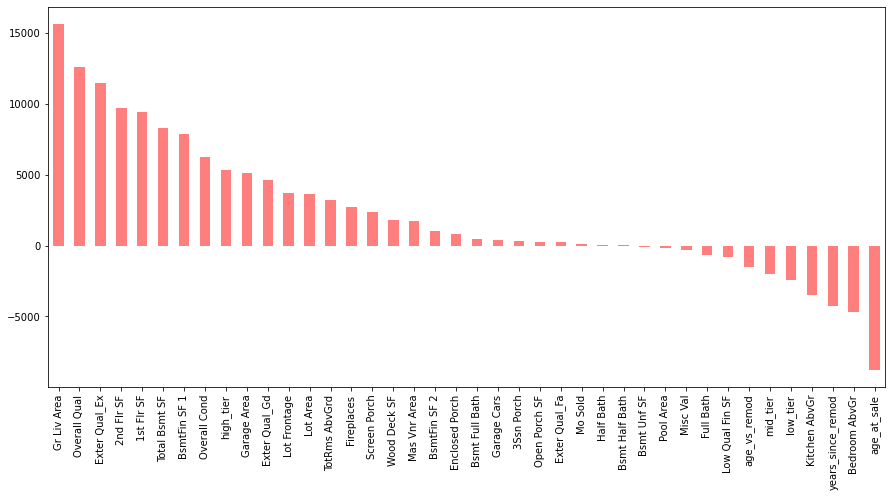

In [14]:
lr_mod(model.lr,feat)

train scores = 0.8964263538475773
test scores = 0.8980160581462567
RMSE(test): 24805.250709356627
Lasso Coef:


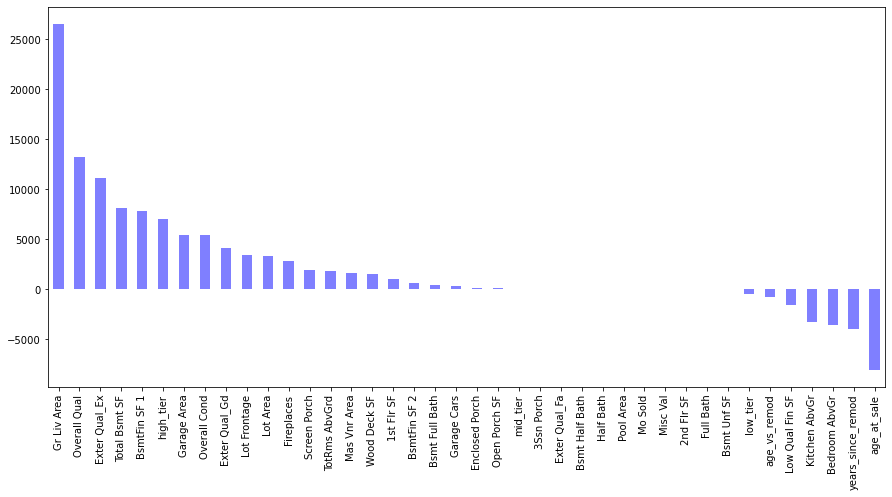

In [15]:
lasso_mod(model.lasso,feat,model.lasso_alpha)

Ridge Train vs Test Scores
R2 Scores:
train scores = 0.8970409692841538
test scores = 0.8982851545324924
RMSE(test): 24772.503336513735
-------
Ridge Coef:


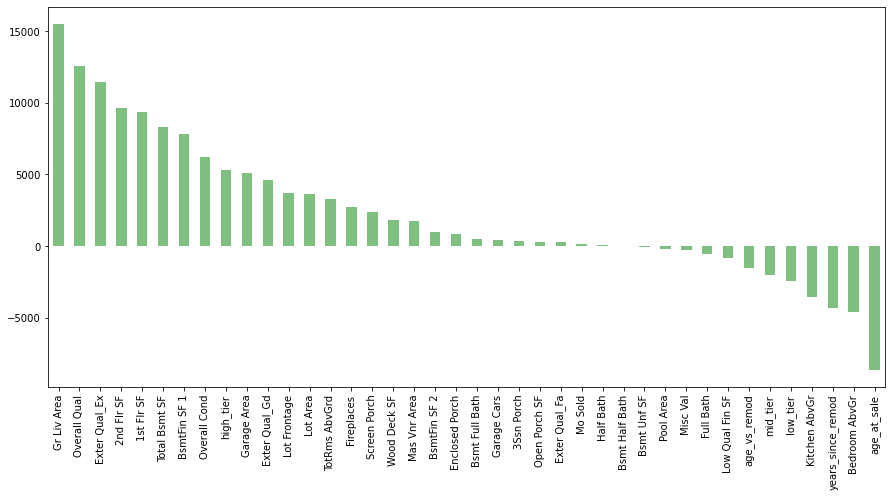

In [16]:
ridge_mod(model.ridge,feat,model.ridge_alpha)

In [17]:
dict_1 = {"n_features": len(feat),
          "lasso_n_alphas": lasso_n_alphas,
          "ridge_lower_alpha": ridge_lower_alpha,
          "ridge_upper_alpha": ridge_upper_alpha,
          "best_lasso_alpha": model.lasso_alpha,
          "best_ridge_alpha": model.ridge_alpha,
          "LR_CV_score": model.lr_scores,
          "lasso_CV_score": model.lasso_scores,
          "ridge_CV_score": model.ridge_scores,
          "lr_train_r2": lr_mod.lr_train_score_r2,
          "lr_test_r2": lr_mod.lr_test_score_r2,
          "lr_rmse": lr_mod.lr_RMSE,
          "lasso_train_r2": lasso_mod.lasso_train_score_r2,
          "lasso_test_r2": lasso_mod.lasso_test_score_r2,
          "lasso_rmse": lasso_mod.lasso_RMSE,
          "ridge_train_r2": ridge_mod.ridge_train_score_r2,
          "ridge_test_r2": ridge_mod.ridge_test_score_r2,
          "ridge_rmse": ridge_mod.ridge_RMSE
         }

In [18]:
results_1 = pd.DataFrame.from_dict(dict_1).T[0]
results_1

n_features              40.000000
lasso_n_alphas         100.000000
ridge_lower_alpha        1.000000
ridge_upper_alpha        5.000000
best_lasso_alpha       394.317984
best_ridge_alpha         4.000000
LR_CV_score          22579.439592
lasso_CV_score       22319.153713
ridge_CV_score       22574.482147
lr_train_r2              0.897043
lr_test_r2               0.898263
lr_rmse              24775.169452
lasso_train_r2           0.896426
lasso_test_r2            0.898016
lasso_rmse           24805.250709
ridge_train_r2           0.897041
ridge_test_r2            0.898285
ridge_rmse           24772.503337
Name: 0, dtype: float64

###### 4.3.2 **Second Iteration: Reduce Number of Features, keep alpha parameters**

In [19]:
feat = trim_feat

In [20]:
model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test

lasso_alpha = 59.93282737861531
ridge_alpha = 4
----------
CV Scores (Root Mean Squared Error)
LR_score = 28419.48009123921
Lasso_score = 28421.69279881026
Ridge_score = 28417.480505319952


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Linear Regression Train vs Test Scores
R2 Scores:
train scores = 0.858024153201465
test scores = 0.8590621185218903
RMSE(test): 29160.273520210874
Linear Regression Coef:


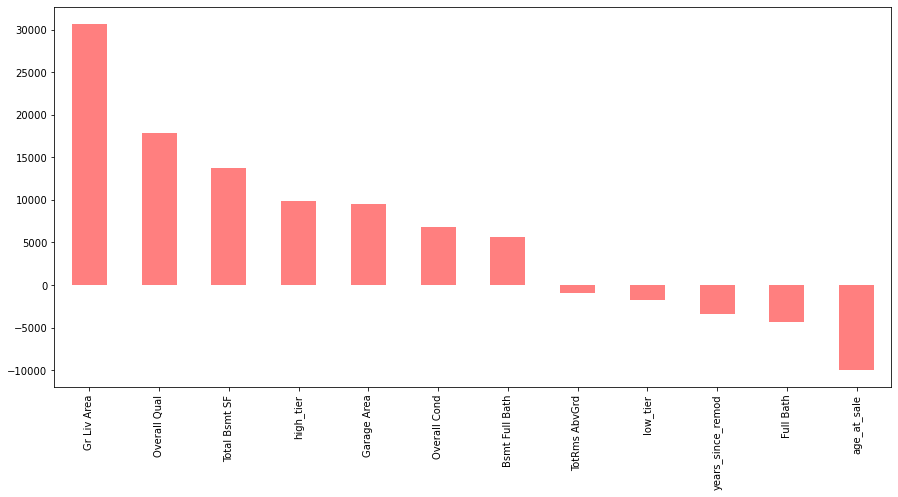

In [21]:
lr_mod(model.lr,feat)

train scores = 0.8580125396038595
test scores = 0.8589398064308497
RMSE(test): 29172.924059948564
Lasso Coef:


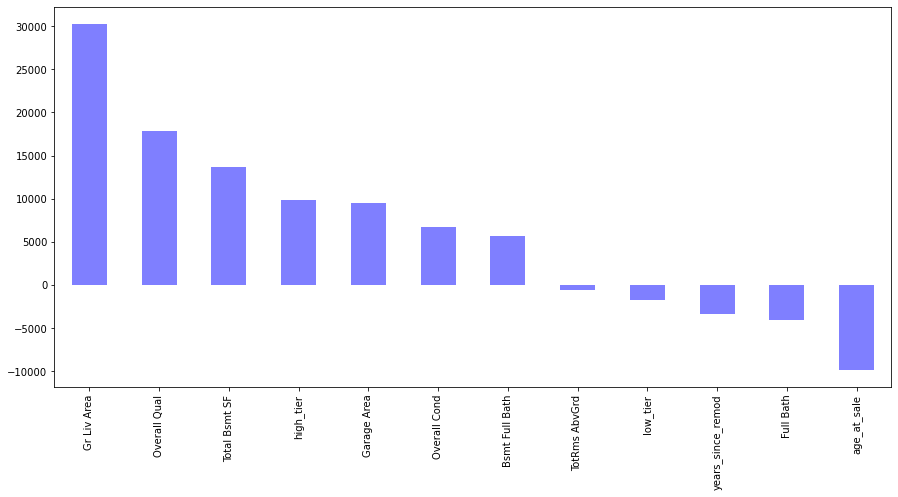

In [22]:
lasso_mod(model.lasso,feat,model.lasso_alpha)

Ridge Train vs Test Scores
R2 Scores:
train scores = 0.8580196388799427
test scores = 0.8589636092685591
RMSE(test): 29170.462601278254
-------
Ridge Coef:


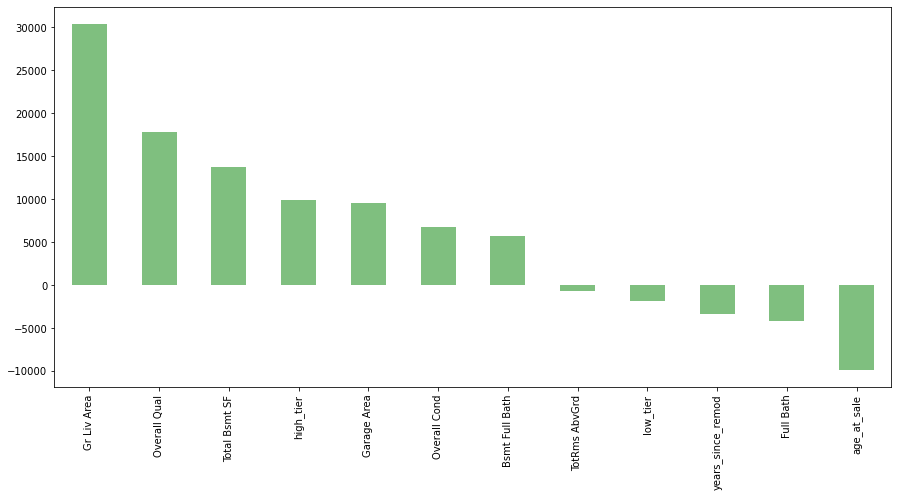

In [23]:
ridge_mod(model.ridge,feat,model.ridge_alpha)

In [24]:
dict_2 = {"n_features": len(feat),
          "lasso_n_alphas": lasso_n_alphas,
          "ridge_lower_alpha": ridge_lower_alpha,
          "ridge_upper_alpha": ridge_upper_alpha,
          "best_lasso_alpha": model.lasso_alpha,
          "best_ridge_alpha": model.ridge_alpha,
          "LR_CV_score": model.lr_scores,
          "lasso_CV_score": model.lasso_scores,
          "ridge_CV_score": model.ridge_scores,
          "lr_train_r2": lr_mod.lr_train_score_r2,
          "lr_test_r2": lr_mod.lr_test_score_r2,
          "lr_rmse": lr_mod.lr_RMSE,
          "lasso_train_r2": lasso_mod.lasso_train_score_r2,
          "lasso_test_r2": lasso_mod.lasso_test_score_r2,
          "lasso_rmse": lasso_mod.lasso_RMSE,
          "ridge_train_r2": ridge_mod.ridge_train_score_r2,
          "ridge_test_r2": ridge_mod.ridge_test_score_r2,
          "ridge_rmse": ridge_mod.ridge_RMSE
         }

In [25]:
results_2 = pd.DataFrame.from_dict(dict_2).T[0]
results_2

n_features              12.000000
lasso_n_alphas         100.000000
ridge_lower_alpha        1.000000
ridge_upper_alpha        5.000000
best_lasso_alpha        59.932827
best_ridge_alpha         4.000000
LR_CV_score          27039.673057
lasso_CV_score       27014.533551
ridge_CV_score       27026.707665
lr_train_r2              0.858024
lr_test_r2               0.859062
lr_rmse              29160.273520
lasso_train_r2           0.858013
lasso_test_r2            0.858940
lasso_rmse           29172.924060
ridge_train_r2           0.858020
ridge_test_r2            0.858964
ridge_rmse           29170.462601
Name: 0, dtype: float64

###### 4.3.3 **Third Iteration: Use trim_feat, update lasso alpha parameters**

In [26]:
lasso_n_alphas = 500
ridge_lower_alpha = 1
ridge_upper_alpha = 50

model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test


lasso_alpha = 59.93282737861531
ridge_alpha = 6
----------
CV Scores (Root Mean Squared Error)
LR_score = 28419.48009123921
Lasso_score = 28421.69279881026
Ridge_score = 28417.00829758758


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Linear Regression Train vs Test Scores
R2 Scores:
train scores = 0.858024153201465
test scores = 0.8590621185218903
RMSE(test): 29160.273520210874
Linear Regression Coef:


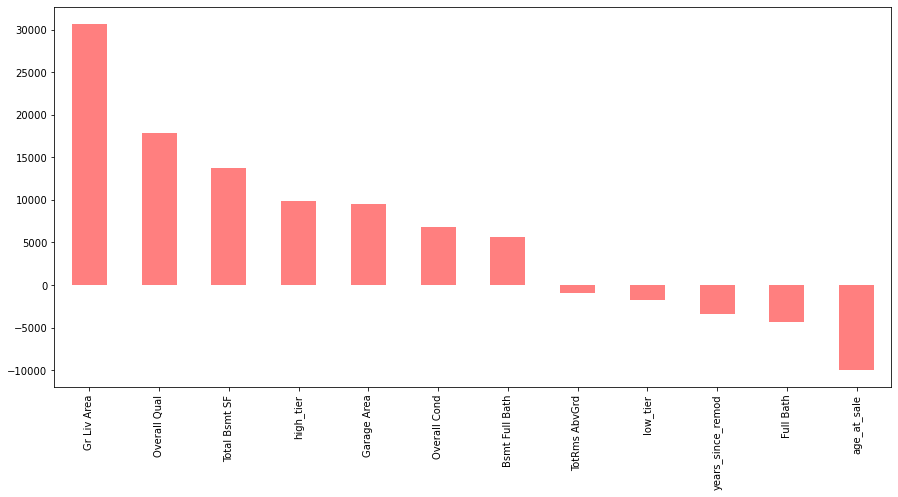

In [27]:
lr_mod(model.lr,feat)

train scores = 0.8580125396038595
test scores = 0.8589398064308497
RMSE(test): 29172.924059948564
Lasso Coef:


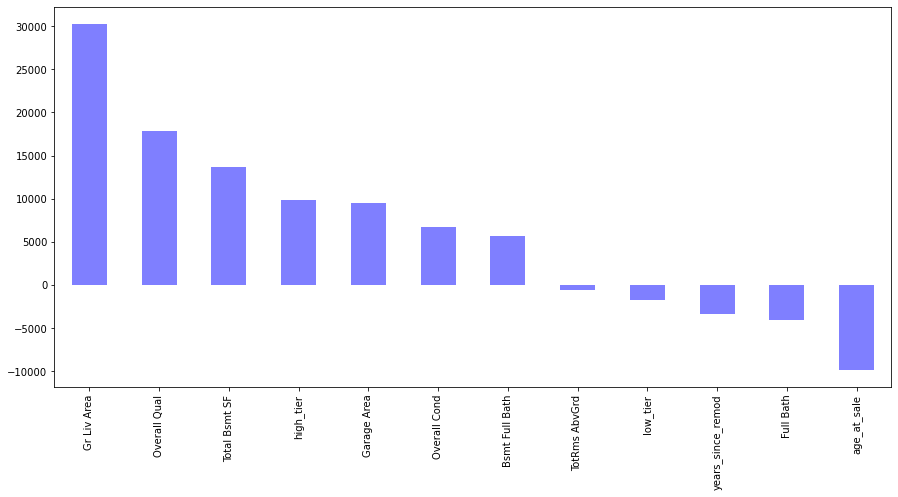

In [28]:
lasso_mod(model.lasso,feat,model.lasso_alpha)

Ridge Train vs Test Scores
R2 Scores:
train scores = 0.8580141363763709
test scores = 0.8589122927552773
RMSE(test): 29175.768998737898
-------
Ridge Coef:


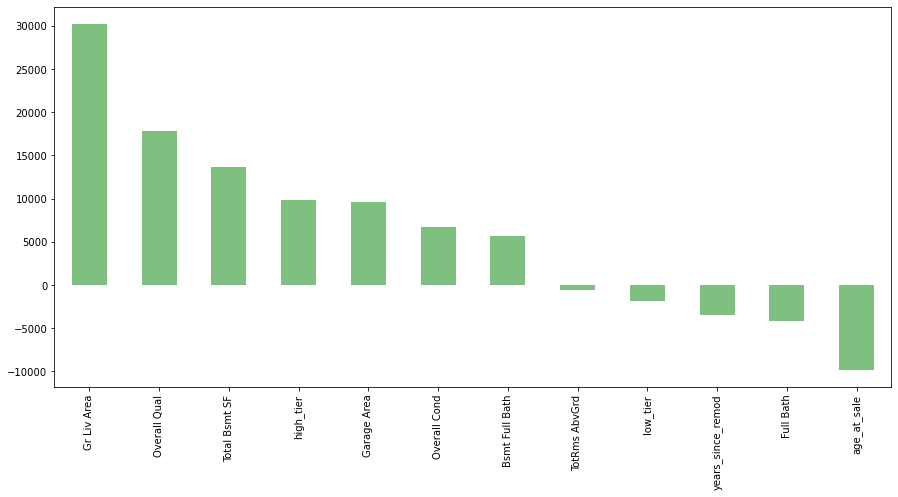

In [29]:
ridge_mod(model.ridge,feat,model.ridge_alpha)

In [30]:
dict_3 = {"n_features": len(feat),
          "lasso_n_alphas": lasso_n_alphas,
          "ridge_lower_alpha": ridge_lower_alpha,
          "ridge_upper_alpha": ridge_upper_alpha,
          "best_lasso_alpha": model.lasso_alpha,
          "best_ridge_alpha": model.ridge_alpha,
          "LR_CV_score": model.lr_scores,
          "lasso_CV_score": model.lasso_scores,
          "ridge_CV_score": model.ridge_scores,
          "lr_train_r2": lr_mod.lr_train_score_r2,
          "lr_test_r2": lr_mod.lr_test_score_r2,
          "lr_rmse": lr_mod.lr_RMSE,
          "lasso_train_r2": lasso_mod.lasso_train_score_r2,
          "lasso_test_r2": lasso_mod.lasso_test_score_r2,
          "lasso_rmse": lasso_mod.lasso_RMSE,
          "ridge_train_r2": ridge_mod.ridge_train_score_r2,
          "ridge_test_r2": ridge_mod.ridge_test_score_r2,
          "ridge_rmse": ridge_mod.ridge_RMSE
         }

results_3 = pd.DataFrame.from_dict(dict_3).T[0]
results_3

n_features              12.000000
lasso_n_alphas         500.000000
ridge_lower_alpha        1.000000
ridge_upper_alpha       50.000000
best_lasso_alpha        59.932827
best_ridge_alpha         6.000000
LR_CV_score          27039.673057
lasso_CV_score       27014.533551
ridge_CV_score       27020.807243
lr_train_r2              0.858024
lr_test_r2               0.859062
lr_rmse              29160.273520
lasso_train_r2           0.858013
lasso_test_r2            0.858940
lasso_rmse           29172.924060
ridge_train_r2           0.858014
ridge_test_r2            0.858912
ridge_rmse           29175.768999
Name: 0, dtype: float64

###### 4.3.4 **Fourth Iteration: Further trim features, keep alpha parameters the same as third iteration**

Dropping Exter Qual_Fa and 'mid_tier' dummies from from Exter_Qual and Neighborhood clusters since coefficients are close to 0.

In [31]:
trim_feat_2 = ['Gr Liv Area',
 '1st Flr SF',
 'Total Bsmt SF',
 'Garage Area',
 'Garage Cars',
 'TotRms AbvGrd',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Full Bath',
 'age_at_sale',
 'years_since_remod',
 'Overall Qual',
 'Overall Cond',
 'Exter Qual_Ex',
 'Exter Qual_Gd',
 'low_tier',
 'high_tier']


In [32]:
feat = trim_feat_2
lasso_n_alphas = 500
ridge_lower_alpha = 1
ridge_upper_alpha = 50

model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test


lasso_alpha = 59.93282737861531
ridge_alpha = 8
----------
CV Scores (Root Mean Squared Error)
LR_score = 26531.688785393962
Lasso_score = 26529.308739485383
Ridge_score = 26526.455627333133


Linear Regression Train vs Test Scores
R2 Scores:
train scores = 0.8781160548304078
test scores = 0.876650991410673
RMSE(test): 27280.074711219786
Linear Regression Coef:


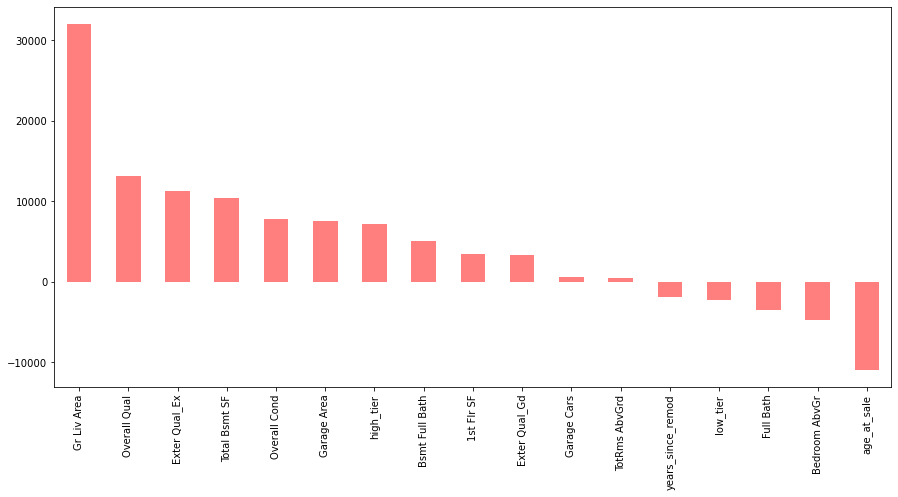

In [33]:
lr_mod(model.lr,feat)

train scores = 0.8781059610226787
test scores = 0.8766807502081231
RMSE(test): 27276.783759807327
Lasso Coef:


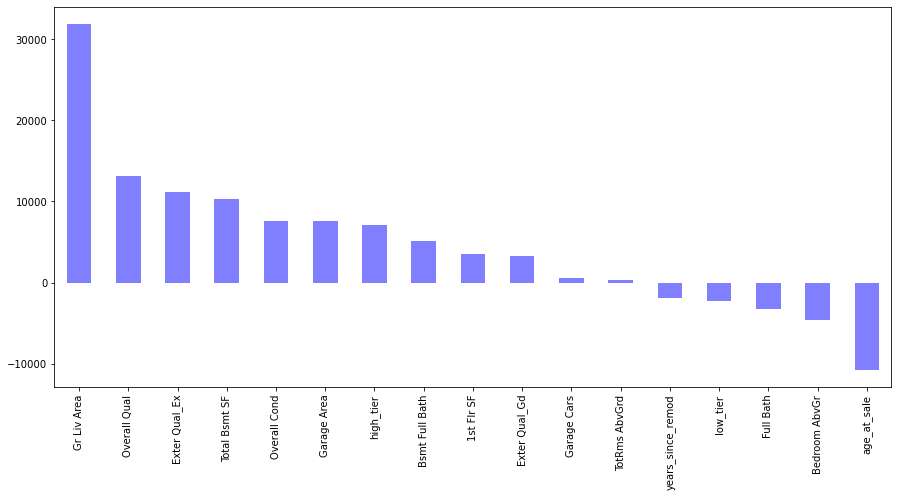

In [34]:
lasso_mod(model.lasso,feat,model.lasso_alpha)

Ridge Train vs Test Scores
R2 Scores:
train scores = 0.8780925676999514
test scores = 0.8766072458953081
RMSE(test): 27284.911698367934
-------
Ridge Coef:


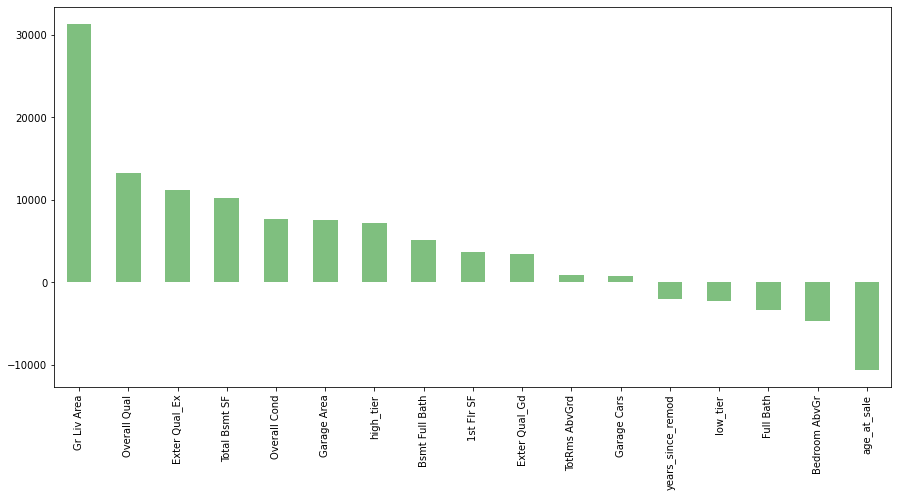

In [35]:
ridge_mod(model.ridge,feat,model.ridge_alpha)

In [36]:
dict_4 = {"n_features": len(feat),
          "lasso_n_alphas": lasso_n_alphas,
          "ridge_lower_alpha": ridge_lower_alpha,
          "ridge_upper_alpha": ridge_upper_alpha,
          "best_lasso_alpha": model.lasso_alpha,
          "best_ridge_alpha": model.ridge_alpha,
          "LR_CV_score": model.lr_scores,
          "lasso_CV_score": model.lasso_scores,
          "ridge_CV_score": model.ridge_scores,
          "lr_train_r2": lr_mod.lr_train_score_r2,
          "lr_test_r2": lr_mod.lr_test_score_r2,
          "lr_rmse": lr_mod.lr_RMSE,
          "lasso_train_r2": lasso_mod.lasso_train_score_r2,
          "lasso_test_r2": lasso_mod.lasso_test_score_r2,
          "lasso_rmse": lasso_mod.lasso_RMSE,
          "ridge_train_r2": ridge_mod.ridge_train_score_r2,
          "ridge_test_r2": ridge_mod.ridge_test_score_r2,
          "ridge_rmse": ridge_mod.ridge_RMSE
         }

results_4 = pd.DataFrame.from_dict(dict_4).T[0]
results_4

n_features              17.000000
lasso_n_alphas         500.000000
ridge_lower_alpha        1.000000
ridge_upper_alpha       50.000000
best_lasso_alpha        59.932827
best_ridge_alpha         8.000000
LR_CV_score          24838.507789
lasso_CV_score       24807.864320
ridge_CV_score       24805.606166
lr_train_r2              0.878116
lr_test_r2               0.876651
lr_rmse              27280.074711
lasso_train_r2           0.878106
lasso_test_r2            0.876681
lasso_rmse           27276.783760
ridge_train_r2           0.878093
ridge_test_r2            0.876607
ridge_rmse           27284.911698
Name: 0, dtype: float64

###### 4.3.5 Fifth Iteration: Remove 2 features from original feat list**, keep alpha parameters the same as fourth iteration

**removing one dummy each from Exter Qual and Neigbourhood features)

In [37]:
combined_feat_2 = ['1st Flr SF',
 '2nd Flr SF',
 '3Ssn Porch',
 'Bedroom AbvGr',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Bsmt Unf SF',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Enclosed Porch',
 'Fireplaces',
 'Full Bath',
 'Garage Area',
 'Garage Cars',
 'Gr Liv Area',
 'Half Bath',
 'Kitchen AbvGr',
 'Lot Area',
 'Lot Frontage',
 'Low Qual Fin SF',
 'Mas Vnr Area',
 'Misc Val',
 'Mo Sold',
 'Open Porch SF',
 'Pool Area',
 'Screen Porch',
 'TotRms AbvGrd',
 'Total Bsmt SF',
 'Wood Deck SF',
 'age_at_sale',
 'years_since_remod',
 'age_vs_remod',
 'Overall Qual',
 'Overall Cond',
 'Exter Qual_Ex',
 'Exter Qual_Gd',
 'low_tier',
 'high_tier']

In [38]:
feat = combined_feat_2
lasso_n_alphas = 500
ridge_lower_alpha = 1
ridge_upper_alpha = 50

model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
y_train = model.y_train
y_test = model.y_test

lasso_alpha = 377.8017495604227
ridge_alpha = 46
----------
CV Scores (Root Mean Squared Error)
LR_score = 25006.199053616685
Lasso_score = 24840.26950545405
Ridge_score = 24966.896833559316


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


Linear Regression Train vs Test Scores
R2 Scores:
train scores = 0.8970312092313686
test scores = 0.8980634144855555
RMSE(test): 24799.490869886213
Linear Regression Coef:


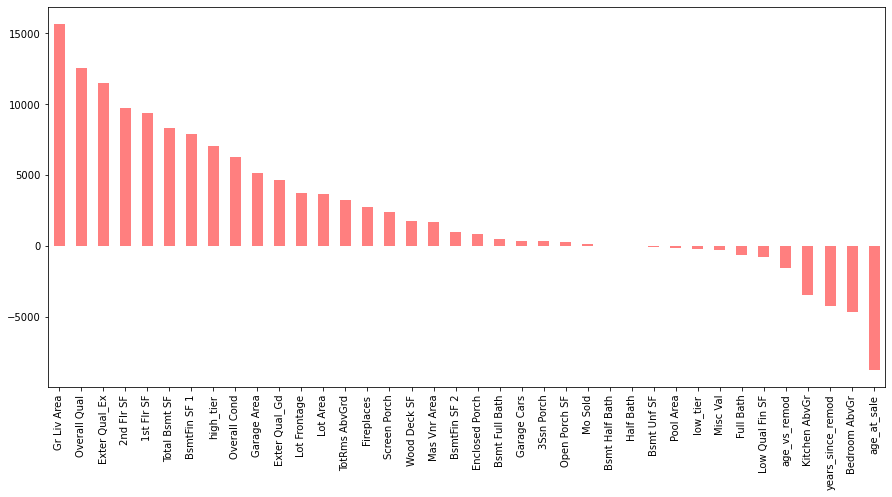

In [39]:
lr_mod(model.lr,feat)

train scores = 0.8964703683171547
test scores = 0.8980305024060508
RMSE(test): 24803.494029989237
Lasso Coef:


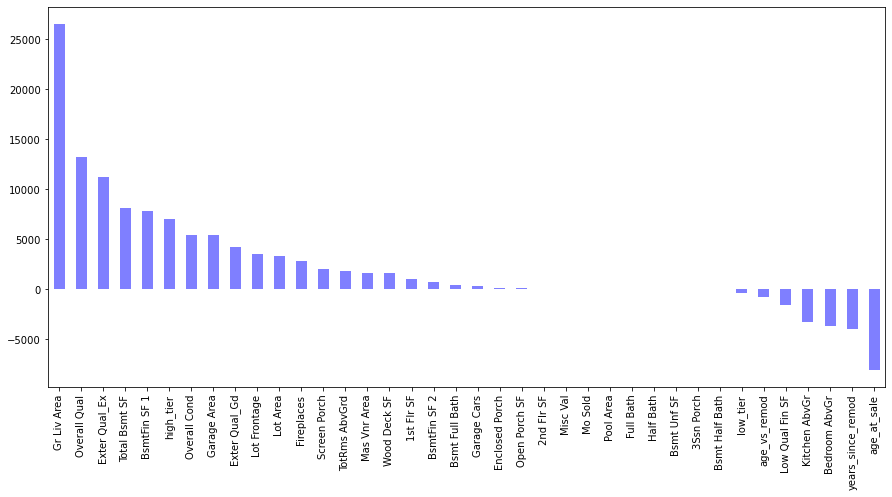

In [40]:
lasso_mod(model.lasso,feat,model.lasso_alpha)

Ridge Train vs Test Scores
R2 Scores:
train scores = 0.8968070125810286
test scores = 0.8981690524744522
RMSE(test): 24786.63754836563
-------
Ridge Coef:


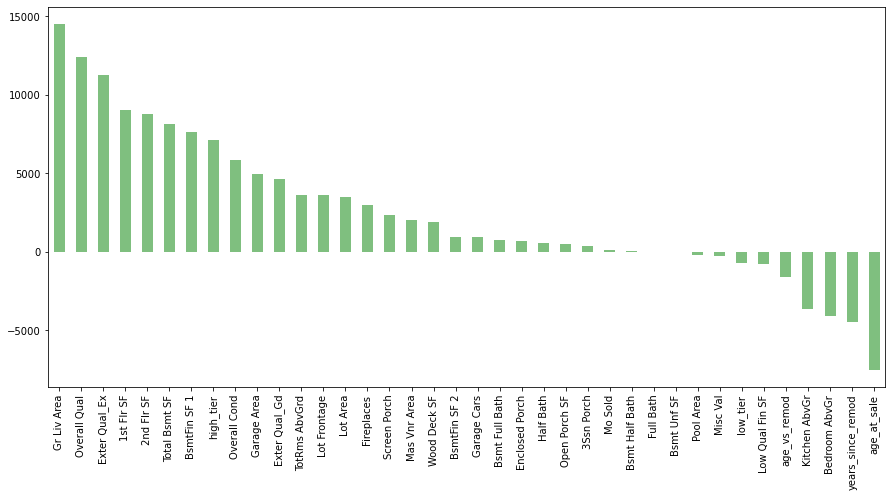

In [41]:
ridge_mod(model.ridge,feat,model.ridge_alpha)

In [42]:
dict_5 = {"n_features": len(feat),
          "lasso_n_alphas": lasso_n_alphas,
          "ridge_lower_alpha": ridge_lower_alpha,
          "ridge_upper_alpha": ridge_upper_alpha,
          "best_lasso_alpha": model.lasso_alpha,
          "best_ridge_alpha": model.ridge_alpha,
          "LR_CV_score": model.lr_scores,
          "lasso_CV_score": model.lasso_scores,
          "ridge_CV_score": model.ridge_scores,
          "lr_train_r2": lr_mod.lr_train_score_r2,
          "lr_test_r2": lr_mod.lr_test_score_r2,
          "lr_rmse": lr_mod.lr_RMSE,
          "lasso_train_r2": lasso_mod.lasso_train_score_r2,
          "lasso_test_r2": lasso_mod.lasso_test_score_r2,
          "lasso_rmse": lasso_mod.lasso_RMSE,
          "ridge_train_r2": ridge_mod.ridge_train_score_r2,
          "ridge_test_r2": ridge_mod.ridge_test_score_r2,
          "ridge_rmse": ridge_mod.ridge_RMSE
         }

results_5 = pd.DataFrame.from_dict(dict_5).T[0]
results_5

n_features              38.000000
lasso_n_alphas         500.000000
ridge_lower_alpha        1.000000
ridge_upper_alpha       50.000000
best_lasso_alpha       377.801750
best_ridge_alpha        46.000000
LR_CV_score          22537.484648
lasso_CV_score       22322.205166
ridge_CV_score       22542.076733
lr_train_r2              0.897031
lr_test_r2               0.898063
lr_rmse              24799.490870
lasso_train_r2           0.896470
lasso_test_r2            0.898031
lasso_rmse           24803.494030
ridge_train_r2           0.896807
ridge_test_r2            0.898169
ridge_rmse           24786.637548
Name: 0, dtype: float64

##### 4.4 Summary of modelling results

In [43]:
final_results = pd.concat([results_1, results_2,results_3,results_4,results_5], axis=1).reset_index()

In [44]:
final_results.columns = ['index','1','2','3','4','5']
index_filter = [i for i in range(18) if i not in [11,14,17]]
final_results.iloc[index_filter,:]

,index,1,2,3,4,5
0,n_features,40.000000,12.000000,12.000000,17.000000,38.000000
1,lasso_n_alphas,100.000000,100.000000,500.000000,500.000000,500.000000
2,ridge_lower_alpha,1.000000,1.000000,1.000000,1.000000,1.000000
3,ridge_upper_alpha,5.000000,5.000000,50.000000,50.000000,50.000000
4,best_lasso_alpha,394.317984,59.932827,59.932827,59.932827,377.801750
5,best_ridge_alpha,4.000000,4.000000,6.000000,8.000000,46.000000
6,LR_CV_score,22579.439592,27039.673057,27039.673057,24838.507789,22537.484648
7,lasso_CV_score,22319.153713,27014.533551,27014.533551,24807.864320,22322.205166
8,ridge_CV_score,22574.482147,27026.707665,27020.807243,24805.606166,22542.076733
9,lr_train_r2,0.897043,0.858024,0.858024,0.878116,0.897031


**Comments**:

1) CV scores here are based on Root Mean Squared Error, so the best performing model is the one with the lowest RMSE.   
2) The more features are incorporated, the better the CV scores, as demonstrated by iterations 1 and 5 above. 
3) The more features are incorporated, the model needs to regularize more by increasing the alpha parameter.
4) In the Lasso model, some features are regularized to zero, as demonstrated in the bar plots above (there is more empty space in the middle of the plots of lasso coefficients as compared to the Linear Regression and Ridge models). 
5) In general, based on R2 scores for both train and test datasets, there is minimal overfitting, and the models above generalize pretty well to new data. 
6) The more features are added, the higher the R2 scores. A R2 score of nearly 90%, indicates that 90% of the variability in Sales Price can be explained by the features chosen in the model. 
7) However, a higher R2 score doesn't necessarily mean the best model, as more features can simply add more noise into the model. 
8) Ideally, we manually select features to reduce multicollinearity. For example, logically, the higher the quality of the house exterior, the better the Overall Quality of the house. Or, the larger the total basement area, the larger the finished area of the basement. 
9) Hence, I have not found the best model here, as iteration 1 and 5 have too many features which are possibly multicollinear, whereas model 3 (with the manually selected features), have too few features at the moment. 
10) For future improvement, I would work on adding more one-hot-encoded categorical features to the model in iteration 3. 

**For the time being, the model selected for Kaggle submission will be the one with the best (lowest) RMSE score, ie: iteration 5.**



In [45]:
feat = combined_feat_2
lasso_n_alphas = 500
ridge_lower_alpha = 1
ridge_upper_alpha = 50

model(feat,lasso_n_alphas,ridge_lower_alpha,ridge_upper_alpha)

X_train_sc = model.X_train_sc
X_test_sc = model.X_test_sc
X_train = model.X_train
y_train = model.y_train
y_test = model.y_test

lasso_alpha = 377.8017495604227
ridge_alpha = 46
----------
CV Scores (Root Mean Squared Error)
LR_score = 25006.199053616685
Lasso_score = 24840.26950545405
Ridge_score = 24966.896833559316


/Users/kenneththesheep/opt/anaconda3/envs/dsi30/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [46]:
kaggle_x = test[combined_feat_2]

ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
kaggle_x_sc = ss.transform(kaggle_x)

lasso = Lasso(alpha = 377.801750)
lasso.fit(X_train_sc,y_train)

lasso_pred = lasso.predict(kaggle_x_sc)


In [47]:
ID = pd.DataFrame(test["Id"])

In [48]:
lasso_pred = pd.DataFrame(lasso_pred)

In [49]:
kaggle = ID.merge(lasso_pred, left_index= True, right_index=True, how="inner")
kaggle.head()

,Id,0
0,2658,151499.196771
1,2718,167440.615498
2,2414,196363.962768
3,1989,112964.659165
4,625,179764.083568


In [50]:
kaggle.rename(columns={0:"SalePrice","Id_x":"Id"},inplace= True)


In [51]:
kaggle

,Id,SalePrice
0,2658,151499.196771
1,2718,167440.615498
2,2414,196363.962768
3,1989,112964.659165
4,625,179764.083568
...,...,...
873,1662,202447.044119
874,1234,225897.893384
875,1373,125368.195877
876,1672,107733.696687


In [52]:
kaggle.to_csv("../dataset/final_pred.csv", index=False)

<img src="../images/KaggleResults.png"
     alt="Kaggle Results"
     style="float: left; margin-right: 10px;" />

The **baseline score** (ie: predictions equal to the mean Sales Price) is 75105.52711. Hence, the model is doing significantly better than the baseline score. 

### Hypothesis Testing (continued)

**RECAP**: Do Above Ground Living Area, Age of Property at Sale, External Quality and Neighborhood have any impact on Property Sale Price?

**Null hypothesis**: Gr Liv Area, Age of Property at Sale, External Quality and Neighborhood DO NOT have any impact on Property Sale Price. The coefficient of these features are equal to zero. 

**Alternative hypothesis**: Gr Liv Area, Age of Property at Sale, External Quality and Neighborhood are significant predictors of Property Sale Price. The coefficient of these features are not equal to zero. 

We will conduct this test assuming $\alpha=0.05$.

In [53]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
model_sm = sm.OLS(y_train, X_train).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     384.3
Date:                Mon, 18 Jul 2022   Prob (F-statistic):               0.00
Time:                        02:13:40   Log-Likelihood:                -18698.
No. Observations:                1625   AIC:                         3.747e+04
Df Residuals:                    1588   BIC:                         3.767e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -2.78e+04   7478.256     -3.718      0.000   -4.25e+04   -1.31e+04
1st Flr SF           24.9200      3.658      6.812      0.000      17.745      32.095
2nd Flr SF           22.4483      3.352      6.697      0.000      15.874      29.023
3Ssn Porch           12.0244     22.866      0.526      0.599     -32.826      56.875
Bedroom AbvGr     -5645.5084   1150.594     -4.907      0.000   -7902.352   -3388.665
Bsmt Full Bath      888.8554   1728.784      0.514      0.607   -2502.084    4279.795
Bsmt Half Bath       56.1832   2625.017      0.021      0.983   -5092.681    5205.047
Bsmt Unf SF          -1.2306      1.532     -0.803      0.422      -4.235       1.774
BsmtFin SF 1         17.2700      1.677     10.297      0.000      13.980      20.560
BsmtFin SF 2          4.7507      2.864      1.659      0.097      -0.867      10.368
Enclosed Porch       13.9692     11.277      1.239      0.216      -8.150      36.089
Fireplaces         4327.1877   1207.093      3.585      0.000    1959.525    6694.851
Full Bath         -1177.4731   1813.859     -0.649      0.516   -4735.283    2380.337
Garage Area          23.7162      6.792      3.492      0.000      10.393      37.039
Garage Cars         463.6710   1943.165      0.239      0.811   -3347.768    4275.110
Gr Liv Area          32.8734      3.466      9.484      0.000      26.075      39.672
Half Bath             3.1159   1784.676      0.002      0.999   -3497.452    3503.684
Kitchen AbvGr      -1.62e+04   3413.388     -4.745      0.000   -2.29e+04   -9502.504
Lot Area              0.5392      0.105      5.151      0.000       0.334       0.745
Lot Frontage        182.9978     35.383      5.172      0.000     113.596     252.399
Low Qual Fin SF     -14.4949      8.459     -1.714      0.087     -31.086       2.097
Mas Vnr Area         10.1854      4.289      2.375      0.018       1.774      18.597
Misc Val             -0.5736      1.275     -0.450      0.653      -3.074       1.927
Mo Sold              46.3542    222.186      0.209      0.835    -389.454     482.162
Open Porch SF         4.3057     10.287      0.419      0.676     -15.872      24.483
Pool Area            -5.5206     18.186     -0.304      0.761     -41.191      30.150
Screen Porch         42.2641     11.365      3.719      0.000      19.972      64.557
TotRms AbvGrd      2091.9209    827.762      2.527      0.012     468.300    3715.542
Total Bsmt SF        20.7902      2.176      9.553      0.000      16.521      25.059
Wood Deck SF         14.1214      5.428      2.601      0.009       3.474      24.769
age_at_sale        -289.9943     46.076     -6.294      0.000    -380.371    -199.618
years_since_remod  -202.6406     54.029     -3.751      0.000    -308.616     -96.666
age_vs_remod       -158.0880     83.884     -1.885      0.060    -322.623

The $p$-value for the above 4 features in the summary table above are 0, which means that $p < \alpha$ and we will reject $H_0$. This means we accept our alternative hypothesis, $H_A$, and accept that these features are a significant predictor of property Sale Price.

In addition, from the Lasso model above, the coefficients of the above features are significantly above/below 0, which indicates they are significant predictors of Sale Price.

### 5. Conclusion

The top 5 predictors of Property Sales Price in Ames, Iowa are:
1) Above Ground Living Area
2) Overall Quality of the Material and Finish of the house
3) Total Basement Sqft Area
4) Neighborhood
5) Age of Property at Sale

<img src="../images/LassoCoef.png"
     alt="Graph"
     style="float: left; margin-right: 10px;" />

**Above Ground Living Area (AGLA)**: Is the strongest predictor of Sales Price. The increase in Sales Price per unit increase of AGLA is nearly double of the impact of Overall Quality. 

**Age of Property at Sale**: The older the property, the lower the Sales Price. It appears that the impact of remodelling on improving Sale Price is minimal.Ie: for older properties, remodelling does little to increase Sale Price. 

This is an important consideration for house-flippers (ie: investors who buy low, and sell high). The cost of remodelling (an old property) needs to be carefully balanced with the (limited) increase in reselling price.

<img src="../images/AgeRemod.png"
     alt="Graph"
     style="float: left; margin-right: 10px;" />

**Neighborhood:** The range of Sale Prices varies by Neighborhood. This can be due to many reasons. 

1) Age of property in the Neighborhood: For example, properties in OldTown are older and thus priced lower. Conversely, properties in NorthRidge Heights are newer and therefore highly priced. 

2) Size of property: NorthRidge Heights are also more highly priced as they have larger above ground living area. 

3) Location and demographics: OldTown and CollegeCreek are nearer to downtown, where Iowa State University is. Prices are capped because most of the house occupants are students. 

*Reference*: [Data Analysis on Real Estate in Ames, Iowa](https://nycdatascience.com/blog/r/data-analysis-on-real-estate-in-ames-iowa/)

<img src="../images/NeighborhoodPrice.png"
     alt="Graph"
     style="float: left; margin-right: 10px;" />

<img src="../images/NeighborhoodGLAAge.png"
     alt="Graph"
     style="float: left; margin-right: 10px;" />

#### 6. Proposed future improvements

1) Further refine the model by studying, selecting and adding more one-hot-encoded (categorical) features. 
2) Collect additional data to study impact of demographics, location and nearby amenities on Sales Price. This will enable property agents to better map seller supply to buyer demand. 